In [9]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import mlab

import os
import json
from glob import glob

# from uncertainties import unumpy as unp
# from uncertainties import ufloat, umath

from options import *
from constants import *

# nom_vals = unp.nominal_values
# std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [ ]:
NFFT = 1024
SAMPLE_RATE = 2_048_000
H21 = 1.420405751768e9  # Hz
#     1.420405751768

In [11]:
def load(dataset: str):
    raw_data = np.fromfile(dataset, np.complex64)
    with open(dataset.replace("raw.dat", "params.json"), "r") as file:
        params = json.load(file)
    
    spectrum, frequencies = mlab.psd(raw_data, NFFT=NFFT, Fs=SAMPLE_RATE)
    frequencies += params['frequency']

    return raw_data, (spectrum, frequencies), params

In [12]:
spectra = []
freq = None

files = glob("../data/Vitesse*.dat")
for file in files:
    _, (spectrum, freq), _ = load(file)
    spectra.append(spectrum)

In [13]:
def calculate_average(spectrum: np.ndarray) -> float:
    idx = np.r_[200:500,550:850]
    return np.mean(spectrum[idx])

In [14]:
def normalise_data(signal: np.ndarray, noise: np.ndarray) -> np.ndarray:
    return signal / noise

In [15]:
def clean_up(signal: np.ndarray, w: int = 10) -> np.ndarray:
    cleaned = np.convolve(signal, np.ones(w), 'same') / w
    return cleaned

In [16]:
def calculate_relative_speed(measured_frequency: float) -> float:
    return sc.constants.c * (H21 - measured_frequency) / measured_frequency

In [17]:
_, (spec, _), _ = load("../data/galactic_test2_2025_02_28_13_46_12_raw.dat")
_, (noise, _), _ = load("../data/bc_test3_2025_02_28_13_31_31_raw.dat")
_, (bm, _), _ = load("../data/batiment_test2_2025_02_28_11_44_57_raw.dat")

In [18]:
def gaussian(x: np.ndarray, A: float, B: float, mu: float, sigma: float) -> np.ndarray:
    return A + B * np.exp(-(x - mu)**2 / (2 * sigma**2))

/tmp/ipykernel_89720/4194066413.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = sc.optimize.curve_fit(gaussian, freq, np.log(cleaned_signal), p0=(calculate_average(cleaned_signal), 1, 1420362000, 1))


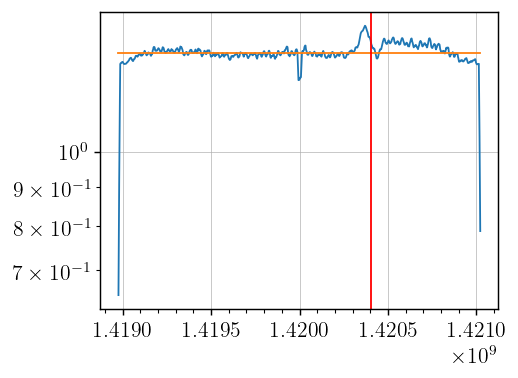

In [23]:
# plt.semilogy(freq, clean_up((spectra[0] / noise)))
# plt.semilogy(freq, clean_up((spectra[1] / noise)))
# plt.semilogy(freq, clean_up((spectra[2] / noise)))
cleaned_signal = clean_up(normalise_data(spec, noise))
plt.semilogy(freq, cleaned_signal)

popt, pcov = sc.optimize.curve_fit(gaussian, freq, np.log(cleaned_signal), p0=(calculate_average(cleaned_signal), 1, 1420362000, 1))

plt.plot(freq, np.exp(gaussian(freq, *popt)))

plt.axvline(H21, c='r')
# Center with redshift 1420362000.0 Hz